In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import cell2location

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected'


In [3]:
adata_wta = sc.read_h5ad(open("/lustre/scratch117/cellgen/team283/Kidney-Nanostring/Kidney_AnnData.h5ad", "rb"))

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
reg_path = "/lustre/scratch117/cellgen/team283/Kidney-Nanostring/scrna/regression_model/RegressionGeneBackgroundCoverageTorch_46covariates_40268cells_10882genes/"
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [5]:
# Column name containing cell type annotations
covariate_col_names = 'celltype'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [6]:
counts_negativeProbes = adata_wta.obsm['negProbes']
counts_nuclei = np.asarray(adata_wta.obs['AOINucleiCount']).reshape(len(adata_wta.obs['AOINucleiCount']),1)

In [7]:
adata_wta.raw = adata_wta

In [8]:
inf_aver.index = np.array(adata_snrna_raw.var.loc[inf_aver.index,'SYMBOL'])

### Summarising single cell clusters ###
### Creating model ### - time 0.0 min
### Analysis name: LocationModelWTA_1experiments_33clusters_231locations_9551genes
### Training model ###


Average Loss = inf:   9%|▉         | 1793/20000 [14:50<2:30:39,  2.01it/s]
Interrupted at 1,793 [8%]: Average Loss = nan


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-f160aca69d14>", line 7, in <module>
    "cell_number_var_prior" : {'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}})
  File "/nfs/team283/aa16/software/miniconda3/envs/c2l/lib/python3.7/site-packages/cell2location-0.5-py3.7.egg/cell2location/run_c2l.py", line 379, in run_cell2location
    n_type=train_args['n_type'], progressbar=verbose)
  File "/nfs/team283/aa16/software/miniconda3/envs/c2l/lib/python3.7/site-packages/cell2location-0.5-py3.7.egg/cell2location/models/base/pymc3_model.py", line 274, in fit_advi_iterative
    progressbar=progressbar, more_replacements=more_replacements)
  File "/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/pymc3/variational/inference.py", line 131, in fit
    step_func = self.

TypeError: object of type 'NoneType' has no len()

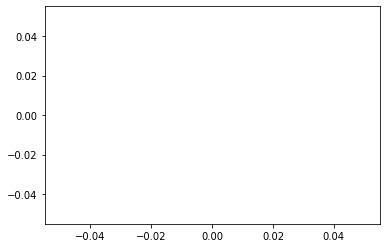

In [9]:
cell2location.run_c2l.run_cell2location(inf_aver, adata_wta, 
        model_name=cell2location.models.LocationModelWTA,
        train_args={'use_raw': True},
        model_kwargs={
        "Y_data" : counts_negativeProbes,
        "cell_number_prior" : {'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 3},
        "cell_number_var_prior" : {'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}})